In [1]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import welch
import scipy.stats as st

from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, f1_score, make_scorer
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

In [2]:
# Define the directory of the train data
from pathlib import Path
train_data_dir = Path('train')

## a. Load the first sample (0.txt) and visualize the acceleration in the x direction of bearing 4. Compare this visualization to 3 other samples from different degradation stages.

In [51]:
# Inspect and load the sample based on the file name.
def data_(file_name):
    sample_file = os.path.join(train_data_dir, file_name)
    bearing_data = pd.read_csv(sample_file, delimiter=';')    

    return bearing_data

# To simplify the visualization, we made a function.
def viz_acceleration_bearing_data(csv_data, y_column, type='line'):
    bearing_data = data_(csv_data)
    y0 = bearing_data[y_column]
    _, Pxx = welch(bearing_data[y_column])
    spectral_flatness = np.exp(np.mean(np.log(Pxx))) / np.mean(Pxx)
    k = st.kurtosis(bearing_data[y_column])

    plt.figure(figsize=(10, 8))
    plt.xlabel('Acceleration (m/s^2)')
    plt.ylabel('Frequency')
    plt.title(f'Acceleration in x-direction of Bearing 4 (Source = {csv_data})')
    # plt.gcf().text(0.85, 0.17, f'Spectral Flatness: {spectral_flatness:.4f}', fontsize=10, horizontalalignment='right')
    # plt.gcf().text(0.85, 0.20, f'Kurtosis: {k:.4f}', fontsize=10, horizontalalignment='right')

    if type == 'line':
        plt.plot(y0)
    
    elif type == 'hist':
        plt.hist(y0)

data_('0.csv')

,b1x,b1y,b4x,b4y
0,-0.022,-0.039,-0.129,-0.142
1,-0.105,-0.017,-0.115,-0.122
2,-0.183,-0.098,-0.171,-0.071
3,-0.178,-0.161,-0.112,-0.078
4,-0.208,-0.129,-0.063,-0.066
...,...,...,...,...
20475,-0.022,-0.142,-0.134,-0.093
20476,0.024,-0.156,-0.227,-0.132
20477,-0.193,-0.303,-0.151,0.007
20478,-0.115,0.076,-0.151,-0.005


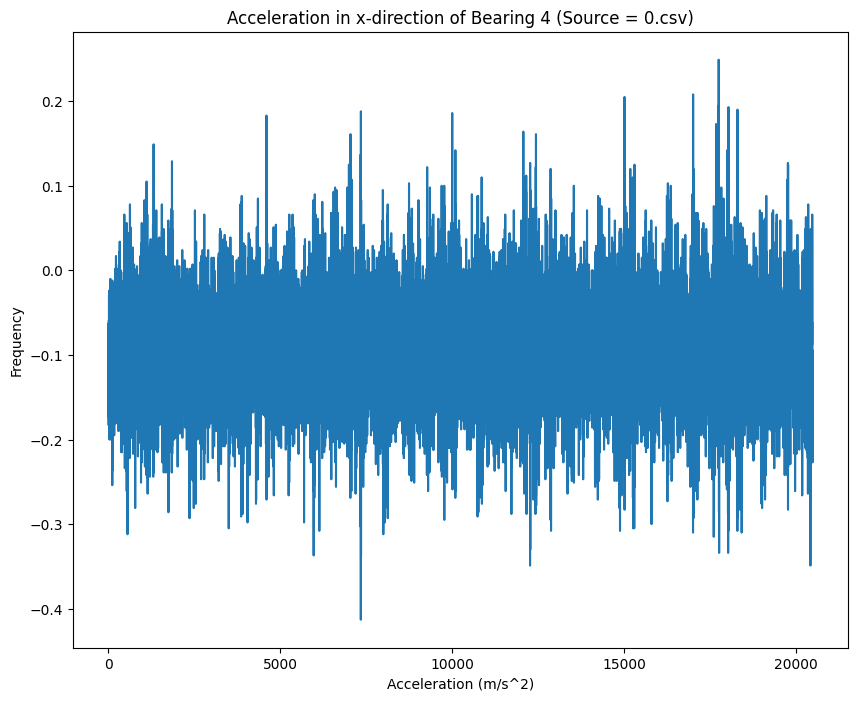

In [4]:
# Load the first sample (0.txt) and visualize the acceleration in the x direction of bearing 4. 
viz_acceleration_bearing_data('0.csv', 'b4x')


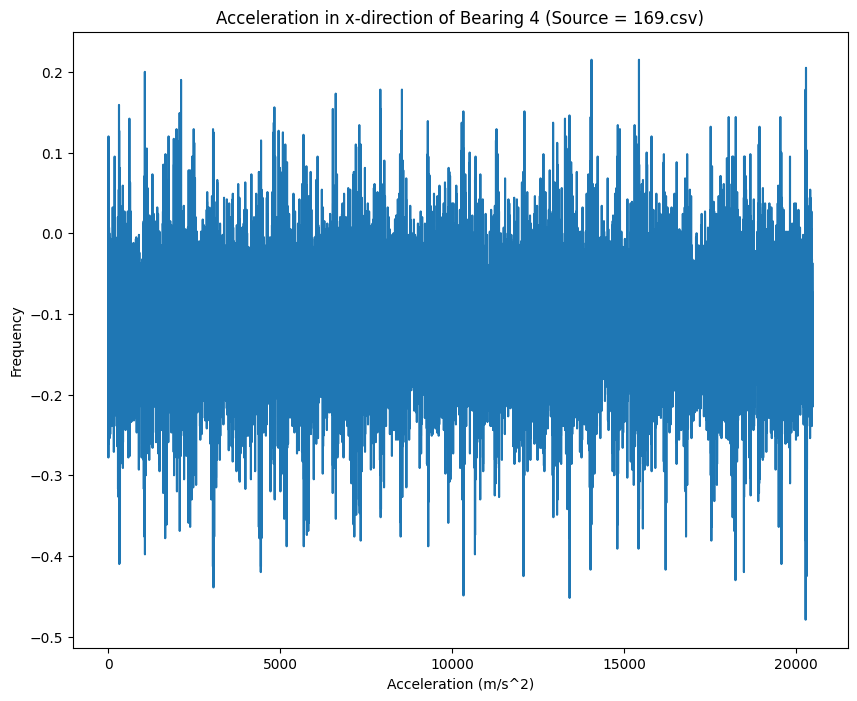

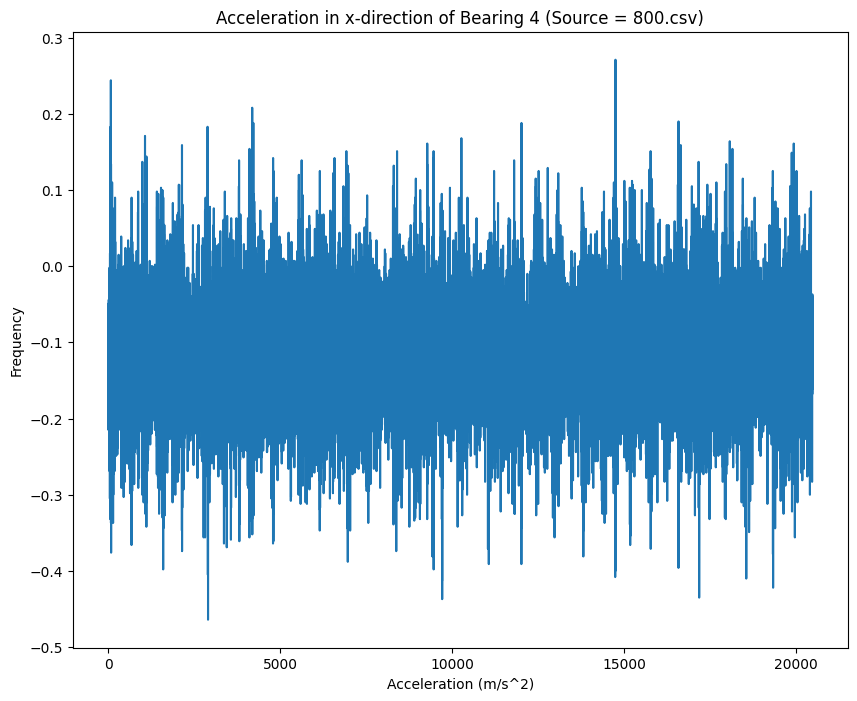

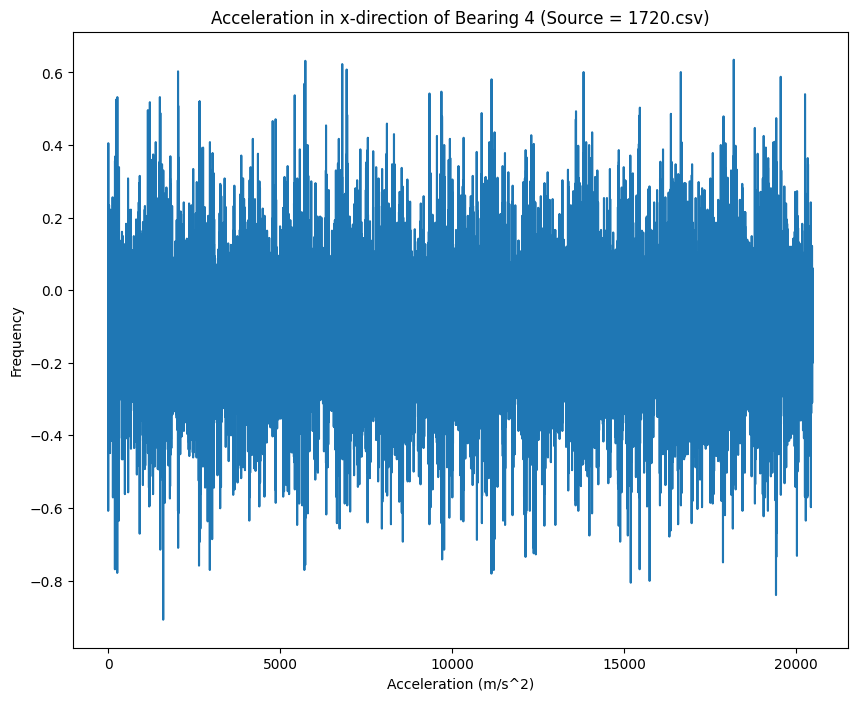

In [5]:
# Compare this visualization to 3 other samples from different degradation stages.
viz_acceleration_bearing_data('169.csv', 'b4x') # Sample from stage 1
plt.show()
viz_acceleration_bearing_data('800.csv', 'b4x') #  Sample from stage 2
plt.show()
viz_acceleration_bearing_data('1720.csv', 'b4x') # Sample from stage 4
plt.show()

# Another thing to point out is the acceleration distribution,
# which stays normal even when the bearing fails or breaks.

## b. Make a function that, given an index, loads the corresponding sample and returns mean, standard deviation, and root mean squared of both x and y acceleration. 

In [6]:
def features_acceleration_data(sample, index=-1):
    # sample = data_(file_name)

    # Make a function that, given an index, loads the corresponding sample and returns mean, standard deviation,
    # and root mean squared of both x and y acceleration.
    if index == -1:
        pass

    elif index or index == 0:
        print(f"Corresponding Sample: ({sample.loc[index, 'b4x']},{sample.loc[index, 'b4y']})")
    
        # Calculates the mean, standard deviation, and
        # root mean squared of both x and y acceleration
        # sample_x = sample.b4x.iloc[index] 
        # sample_y = sample.b4y.iloc[index] 

    mean_x = sample.b4x.mean()
    mean_y = sample.b4y.mean()
    std_x = sample.b4x.std()
    std_y = sample.b4y.std()
    rms_x = np.sqrt(np.mean(sample.b4x**2))
    rms_y = np.sqrt(np.mean(sample.b4y**2))
    
    # First feature to add: Spectral Flatness
    _, Pxx_x = welch(sample.b4x)
    spectral_flatness_x = np.exp(np.mean(np.log(Pxx_x))) / np.mean(Pxx_x)
    _, Pxy_y = welch(sample.b4y)
    spectral_flatness_y = np.exp(np.mean(np.log(Pxy_y))) / np.mean(Pxy_y)

    # Second feature to add:
    # peak_to_peak_x = np.ptp(sample.b4x)
    # peak_to_peak_y = np.ptp(sample.b4y)

    kurtosis_x = st.kurtosis(sample.b4x)
    kurtosis_y = st.kurtosis(sample.b4y)

    features = {
    #     'x_acc': sample.loc[index, 'b4x'],
    #     'y_acc': sample.loc[index, 'b4y'],
        'mean_x': mean_x,
        'mean_y': mean_y,
        'std_x': std_x,
        'std_y': std_y,
        'rms_x': rms_x,
        'rms_y': rms_y,
        'spectral_flatness_x': spectral_flatness_x,
        'spectral_flatness_y': spectral_flatness_y,
        # 'peak_to_peak_x': peak_to_peak_x,
        # 'peak_to_peak_y': peak_to_peak_y,
        'kurtosis_x': kurtosis_x,
        'kurtosis_y': kurtosis_y
    }
    return features
    
features_acceleration_data(data_('0.csv'))

{'mean_x': -0.09096875,
 'mean_y': -0.094235205078125,
 'std_x': 0.06008602164049359,
 'std_y': 0.0663816272503547,
 'rms_x': 0.10902048975995292,
 'rms_y': 0.1152674244979501,
 'spectral_flatness_x': 0.5962608450036389,
 'spectral_flatness_y': 0.8044983999172042,
 'kurtosis_x': 0.7902499085116994,
 'kurtosis_y': 1.8079901941922039}

## c. Apply the function from b. to the entire dataset and store your results in a dataframe. Perform some explanatory data analysis to get some insight on which classification models might be suitable for predicting the degradation stage.

In [7]:
# List to store feature data
feature_list = []

def extract_numeric_part(file_name):
    """Extract numeric part from file name assuming it is an integer."""
    return int(''.join(filter(str.isdigit, file_name)))

try:
    # Get list of files
    file_names = os.listdir(train_data_dir)
    int_file_names = []
    for file_name in file_names:
        int_file_names.append(extract_numeric_part(file_name))

    # Sort files by numeric part
    sorted_file_names = sorted(int_file_names)

    # Calculate features
    file_names = [f"{file_name}.csv" for file_name in sorted_file_names]

    for file_name in file_names:
        features = features_acceleration_data(data_(file_name))
        
        if features:
            # Append the features to the list
            feature_list.append(features)
            
except AttributeError:
    print(file_name)

except ValueError:
    print(file_name)
    
# Dataframe of the appended features
feature_df = pd.DataFrame(feature_list)

In [8]:
bearing_data = pd.read_csv('bearing_conditions.csv')
feature_df['b4_state'] = bearing_data['b4_state']
feature_df

,mean_x,mean_y,std_x,std_y,rms_x,rms_y,spectral_flatness_x,spectral_flatness_y,kurtosis_x,kurtosis_y,b4_state
0,-0.090969,-0.094235,0.060086,0.066382,0.109020,0.115267,0.596261,0.804498,0.790250,1.807990,0
1,-0.091260,-0.087946,0.059421,0.064746,0.108900,0.109208,0.584145,0.783668,1.234703,1.873189,0
2,-0.092597,-0.093106,0.059969,0.065255,0.110319,0.113696,0.583899,0.790509,0.924708,1.429695,0
3,-0.093485,-0.093244,0.059917,0.066303,0.111037,0.114413,0.591183,0.785778,0.652667,1.378184,0
4,-0.104769,-0.093042,0.058607,0.065404,0.120046,0.113729,0.607559,0.792167,0.687223,1.128042,0
...,...,...,...,...,...,...,...,...,...,...,...
1719,-0.114535,-0.113543,0.170076,0.153969,0.205043,0.191304,0.436379,0.731373,0.605404,0.593077,4
1720,-0.114403,-0.114376,0.173063,0.155483,0.207455,0.193017,0.428962,0.719231,0.666509,0.671058,4
1721,-0.114999,-0.115266,0.204396,0.173419,0.234522,0.208228,0.349937,0.619248,0.798884,0.536752,4
1722,-0.114991,-0.115953,0.186758,0.165808,0.219317,0.202326,0.414284,0.679173,0.581410,0.562985,4


## c. Exploratory Data Analysis for Classification Model


In [26]:
features = ['spectral_flatness_x', 'spectral_flatness_y', 'kurtosis_x', 'kurtosis_y', 'mean_x', 'mean_y', 'std_x', 'std_y', 'rms_x', 'rms_y']
X = feature_df[features]
y = feature_df['b4_state']
train, test = train_test_split(feature_df, train_size = 0.80, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state = 42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


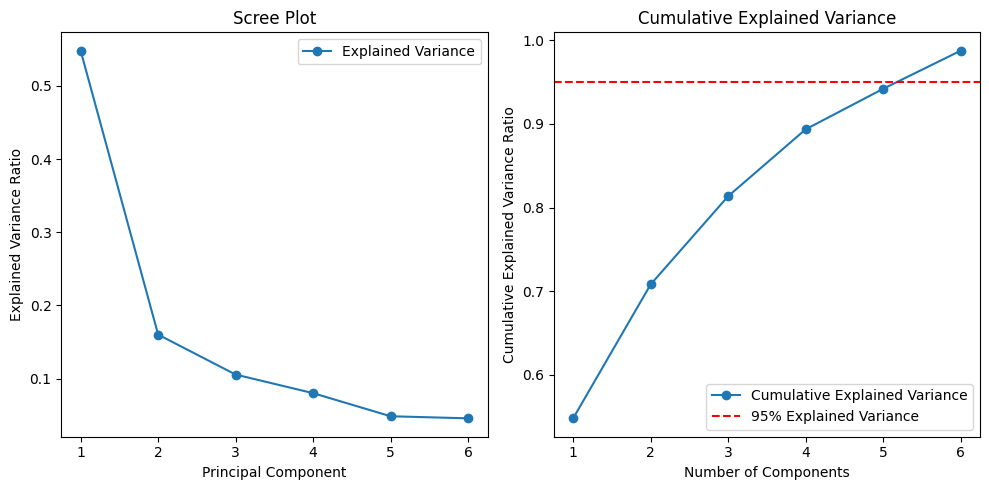

Number of components to retain for 95% explained variance: 6


In [27]:
# High multicollinearity exists between many variables,
# and thus, we decided to do some feature selection.
# We still want to retain the variance of the model, and fortunately,
# we can use a function in PCA for this
# (another reason why we apply PCA other than dimension reduction)

# Firstly, we examin the explained variance of each component
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

# Plot the explained variance
plt.figure(figsize=(10, 5))

# Scree plot
# displays the variance explained by each principal component.
# how much each component contributes to explaining the variance in the data.

plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, 'o-', label='Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend()

# Cumulative explained variance plot
# This plot shows how the explained variance accumulates
# as more components are added.
# The red dashed line (at 95%) ensure the number of components to
# retain 95% of explained variance.

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, 'o-', label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance')
plt.legend()

plt.tight_layout()
plt.show()

# Determine the number of components for 95% explained variance
num_components = np.where(cumulative_explained_variance >= 0.95)[0][0] + 1
print(f'Number of components to retain for 95% explained variance: {num_components}')


In [39]:
# Using the specified number of components to retain the explained variance
# (Cumulative Explain Variance Plot), 
# perform feature selection using RFE and evaluate the model.

def feature_selection(model, X, y, num_components, cv=5):
    
    rfe = RFE(model, n_features_to_select=num_components)
    X_rfe = rfe.fit_transform(X, y)
    X_test_rfe = rfe.transform(X_test_pca)

    rf_scores_tr = cross_val_score(model, X_rfe, y_train, cv=cv)
    print(f'Cross-Validation Score (Train): {np.mean(rf_scores_tr)}')
    rf_scores = cross_val_score(model, X_test_rfe, y_test, cv=cv)
    print(f'Cross-Validation Score (Test): {np.mean(rf_scores)}')

    return X_rfe, X_test_rfe
# Use RF model that gives the least difference between Train and Test Score
X_rfe, X_test_rfe = feature_selection(RandomForestClassifier(max_depth=6, n_estimators=200, random_state=42), X, y_train)

Cross-Validation Score (Train): 0.8730882740447958
Cross-Validation Score (Test): 0.881159420289855


In [13]:
def time_trend_visualization(y1, y2, column_label, legend_location = 'upper left'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    cmap = {
        0: 'cyan',
        1: 'green',
        2: 'yellow',
        3: 'orange',
        4: 'pink'
    }

    legend_labels = {
        0: 'Early',
        1: 'Normal',
        2: 'Suspect',
        3: 'Roll element failure',
        4: 'Stage 2 failure'
    }

    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=c) for c in cmap.values()]

    for ax, y, label in [(ax1, y1, f'{column_label} X'), (ax2, y2, f'{column_label} Y')]:
        ax.plot(y, label=label, color='blue')
        for i in range(len(y) - 1):
            ax.axvspan(i, i+1, alpha=0.5, color=cmap[feature_df.b4_state.iloc[i]])
            
        ax.legend(handles=[plt.Line2D([0], [0], color='blue', lw=2, label=label)] + legend_handles, 
                labels=[label] + list(legend_labels.values()), title='bearing degradation state', loc=legend_location)
            
        ax.set_xlim([0, 1750])
        ax.set_xlabel('Time')
        ax.set_ylabel(f'{label} Value')
        ax.set_title(f'{label} Value Trend Over Time')

    plt.show()

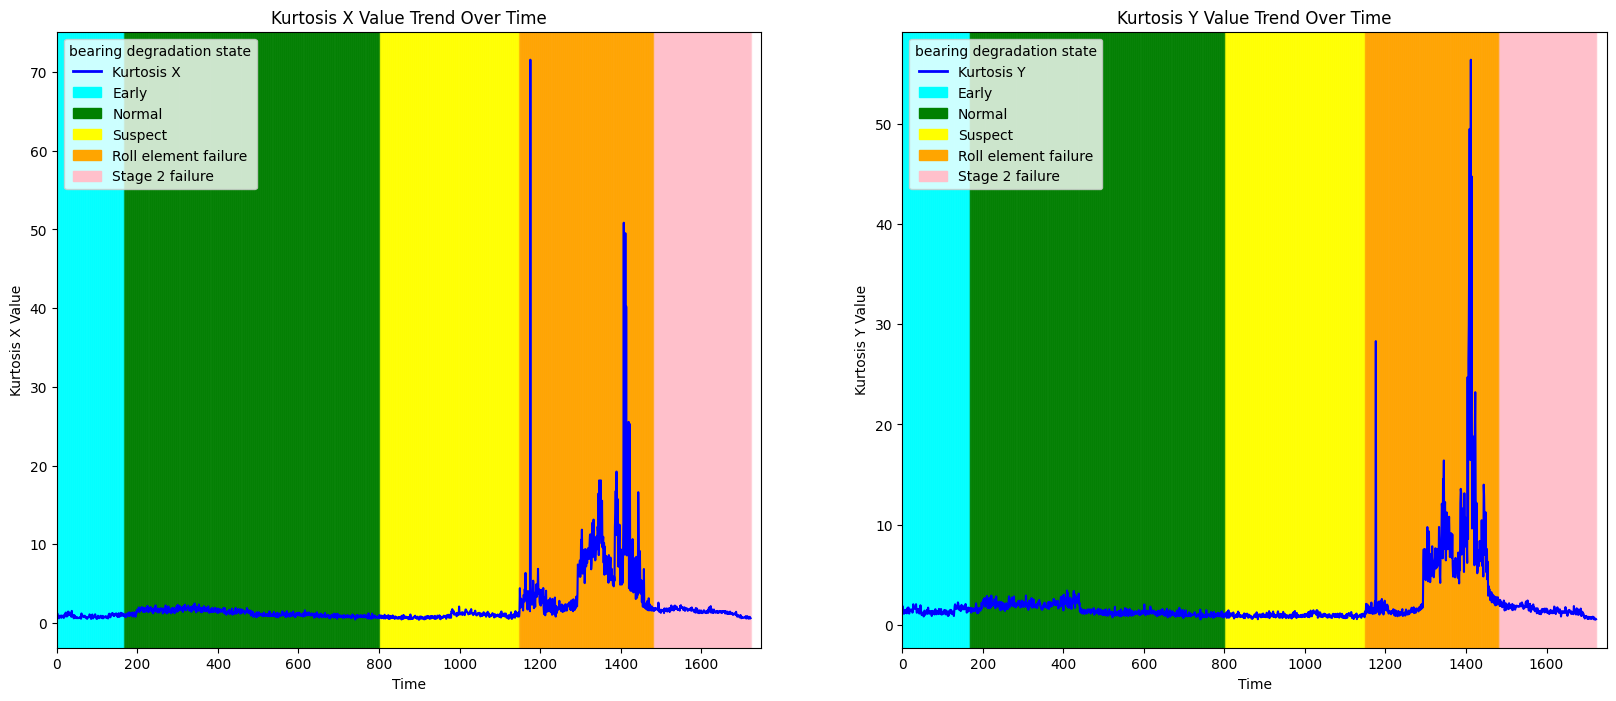

In [14]:
time_trend_visualization(feature_df.kurtosis_x, feature_df.kurtosis_y, 'Kurtosis')

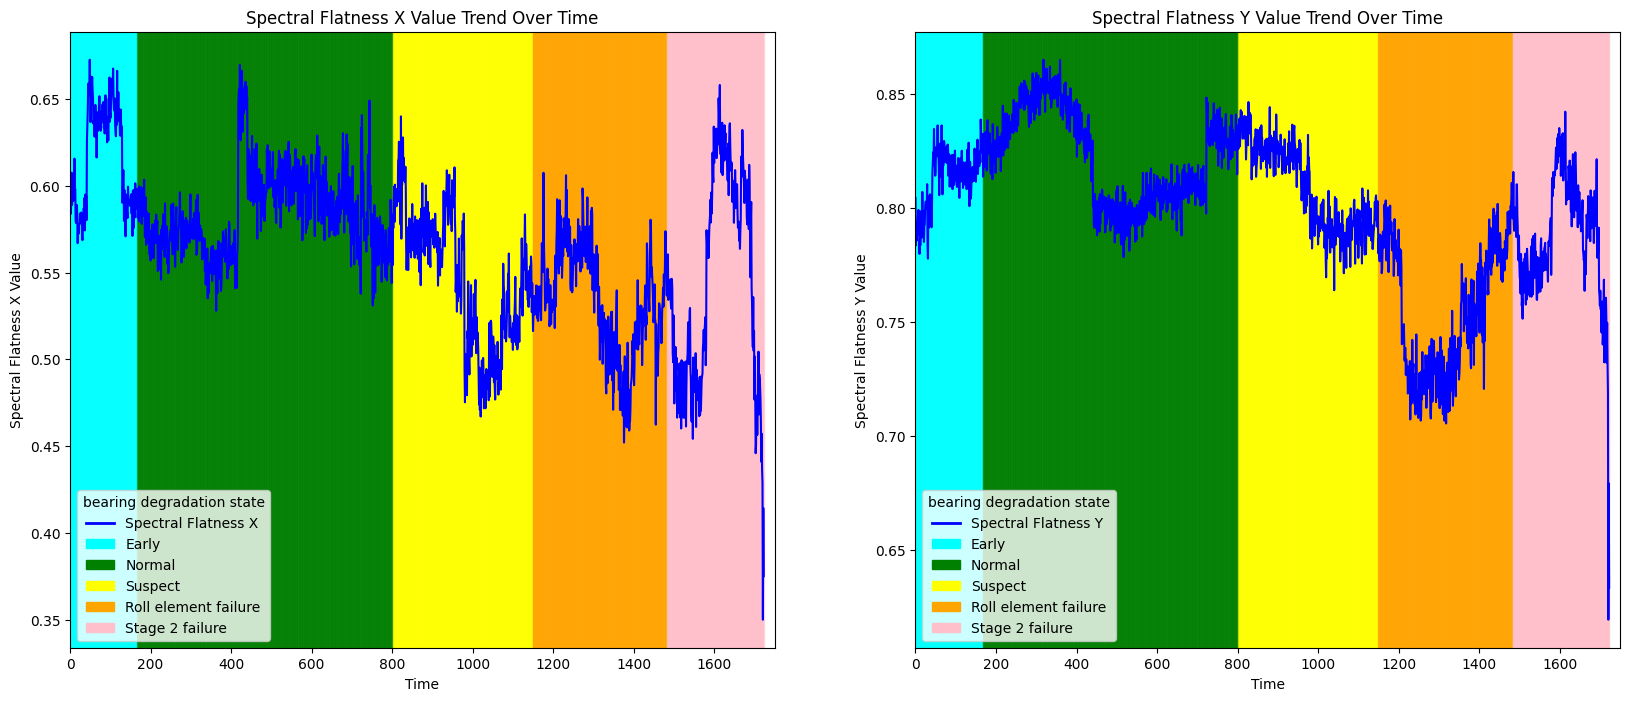

In [15]:
time_trend_visualization(feature_df.spectral_flatness_x, feature_df.spectral_flatness_y, 'Spectral Flatness', legend_location='lower left')

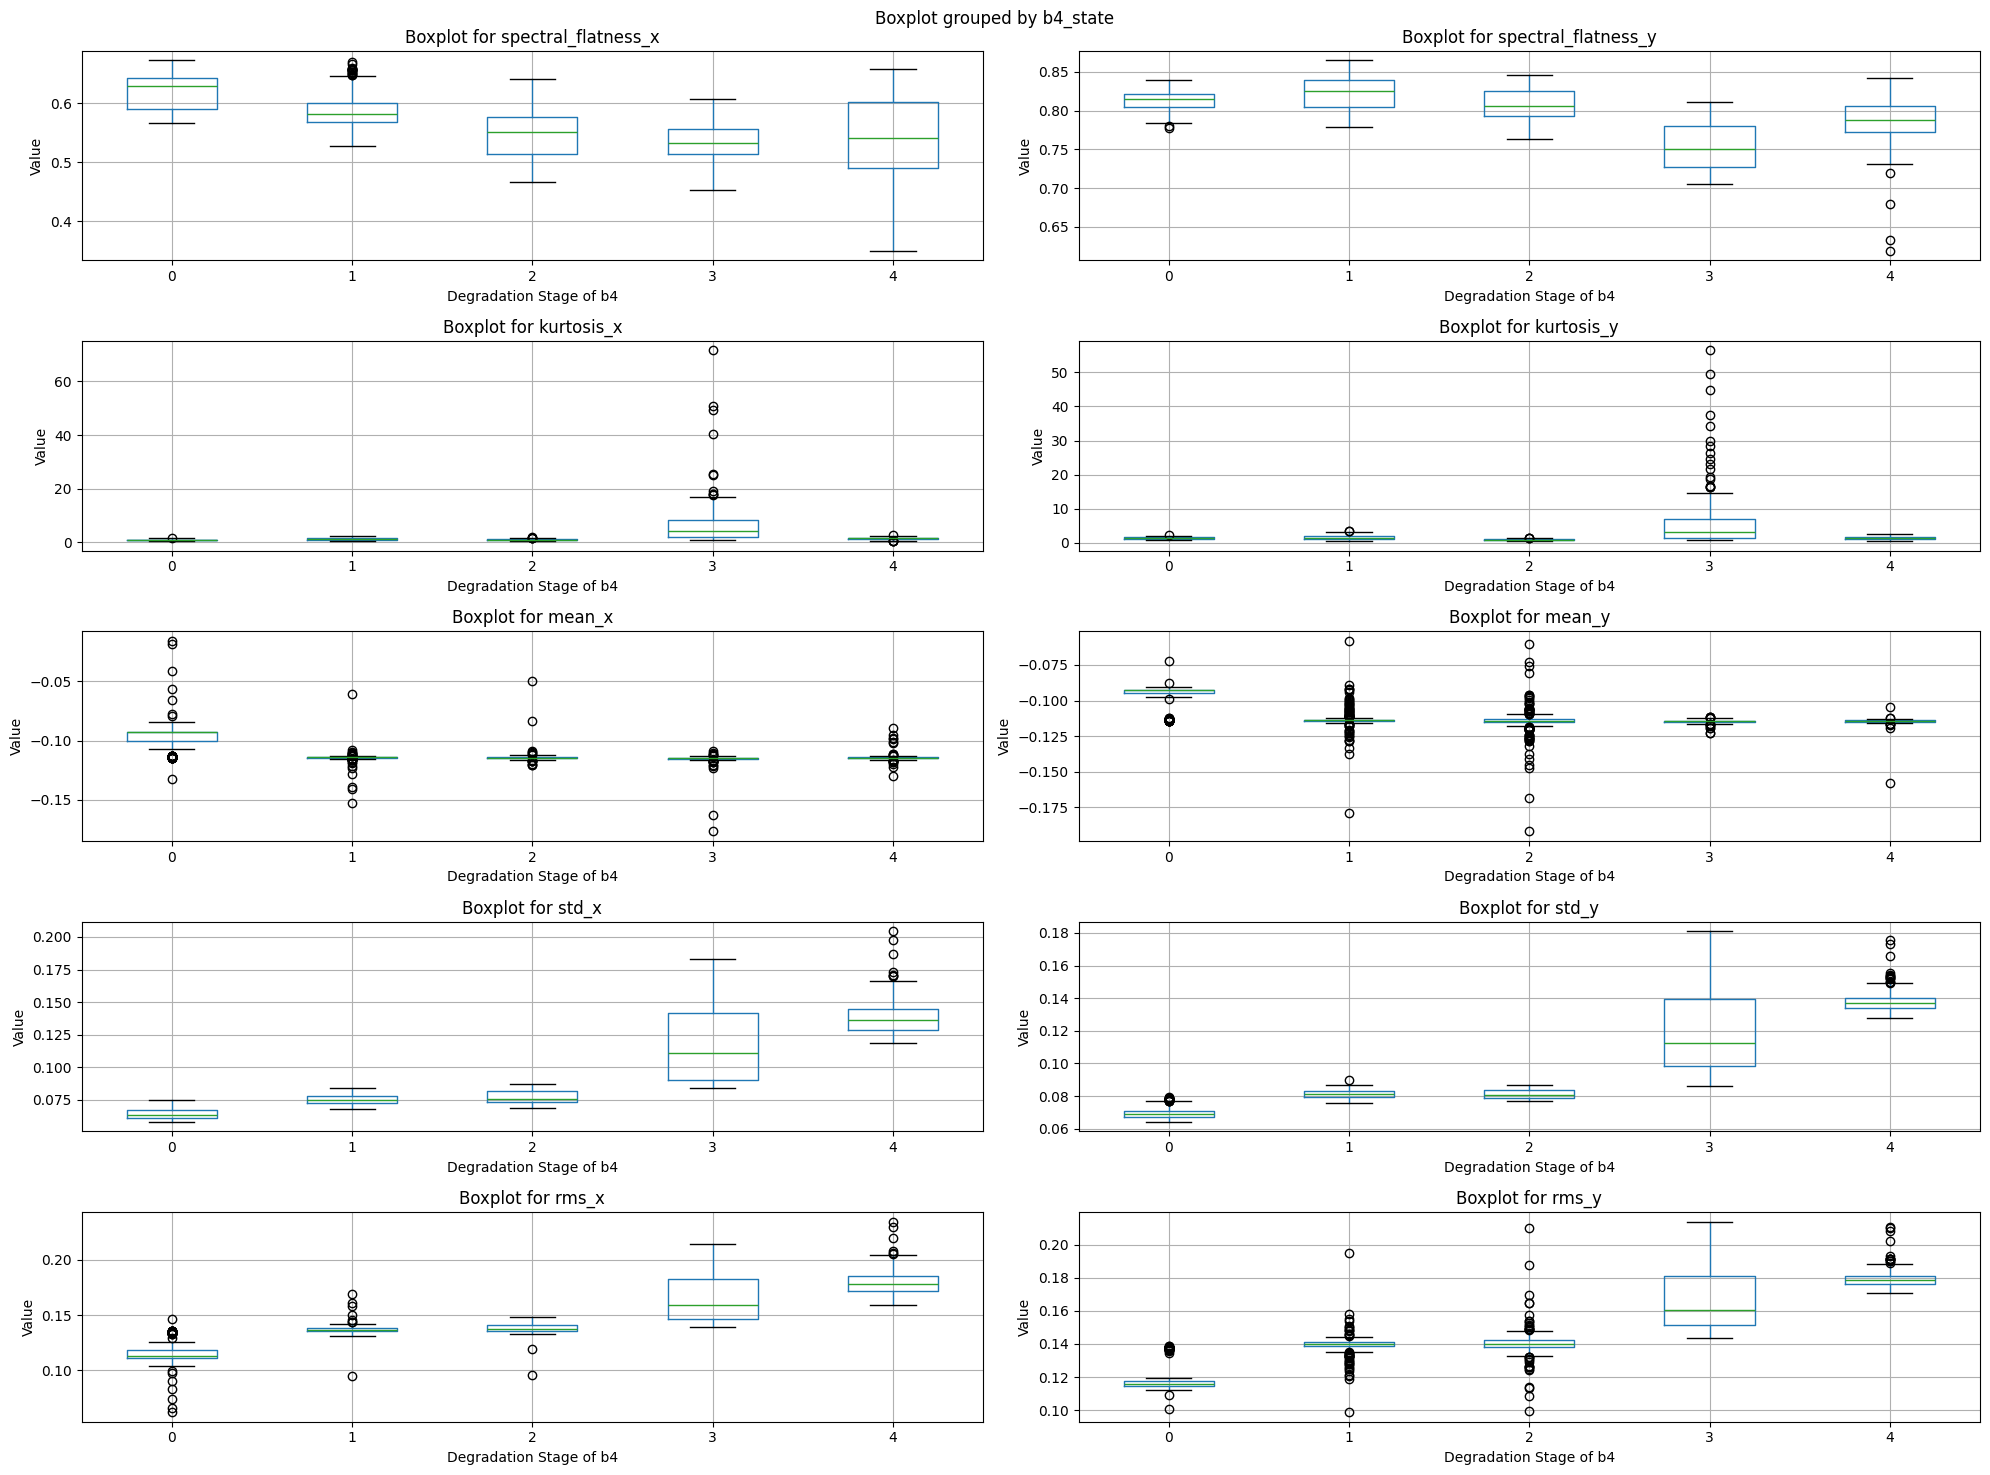

In [49]:
# Firstly, we make some boxplots based on each feature in the dataframe
# to understand the distribution of these variable.

num_features = len(features)
ncols = 2
nrows = (num_features + 1) // 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))

for i, feature in enumerate(features):
    row, col = divmod(i, ncols)
    ax = axes[row, col]
    feature_df.boxplot(column=feature, ax=ax, by='b4_state')
    ax.set_title(f'Boxplot for {feature}')
    ax.set_xlabel('Degradation Stage of b4')
    ax.set_ylabel('Value')

# Remove empty subplots if any
for j in range(i + 1, nrows * ncols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

# We can see that there are a few outliers throughout all features.
# The presence of outlier has to be taken into account when choosing a Machine Learning model later

In [17]:
# # Create a separate boxplot for each feature
# for i, feature in enumerate(features):
#     plt.figure(figsize=(10, 6))
#     feature_df.boxplot(column=feature, by='b4_state')
#     plt.title(f'Boxplot for {feature}')
#     plt.xlabel('Degradation Stage of b4')
#     plt.ylabel('Value')
#     plt.show()

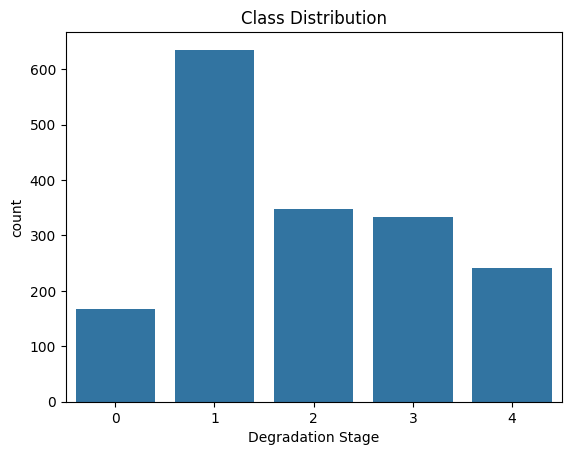

In [18]:
# Check the class distribution
sns.countplot(x=feature_df['b4_state'], data=feature_df)
plt.title('Class Distribution')
plt.xlabel('Degradation Stage')
plt.show()

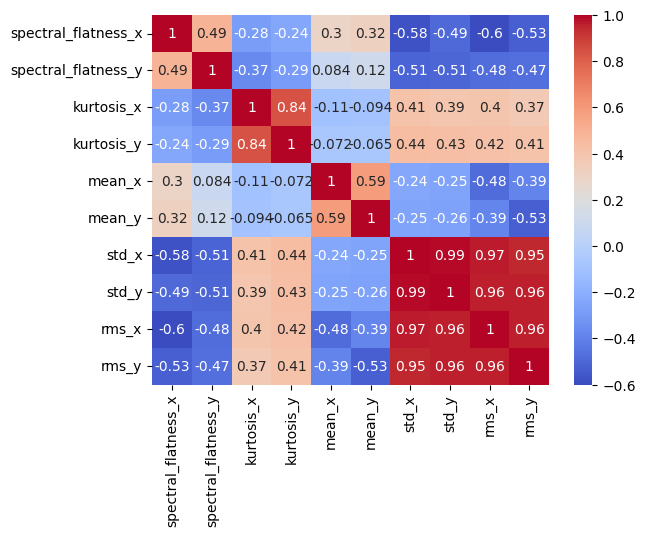

In [19]:
# Correlation Matrix of features
sns.heatmap(feature_df[features].corr(), annot=True, cmap='coolwarm')
plt.show()

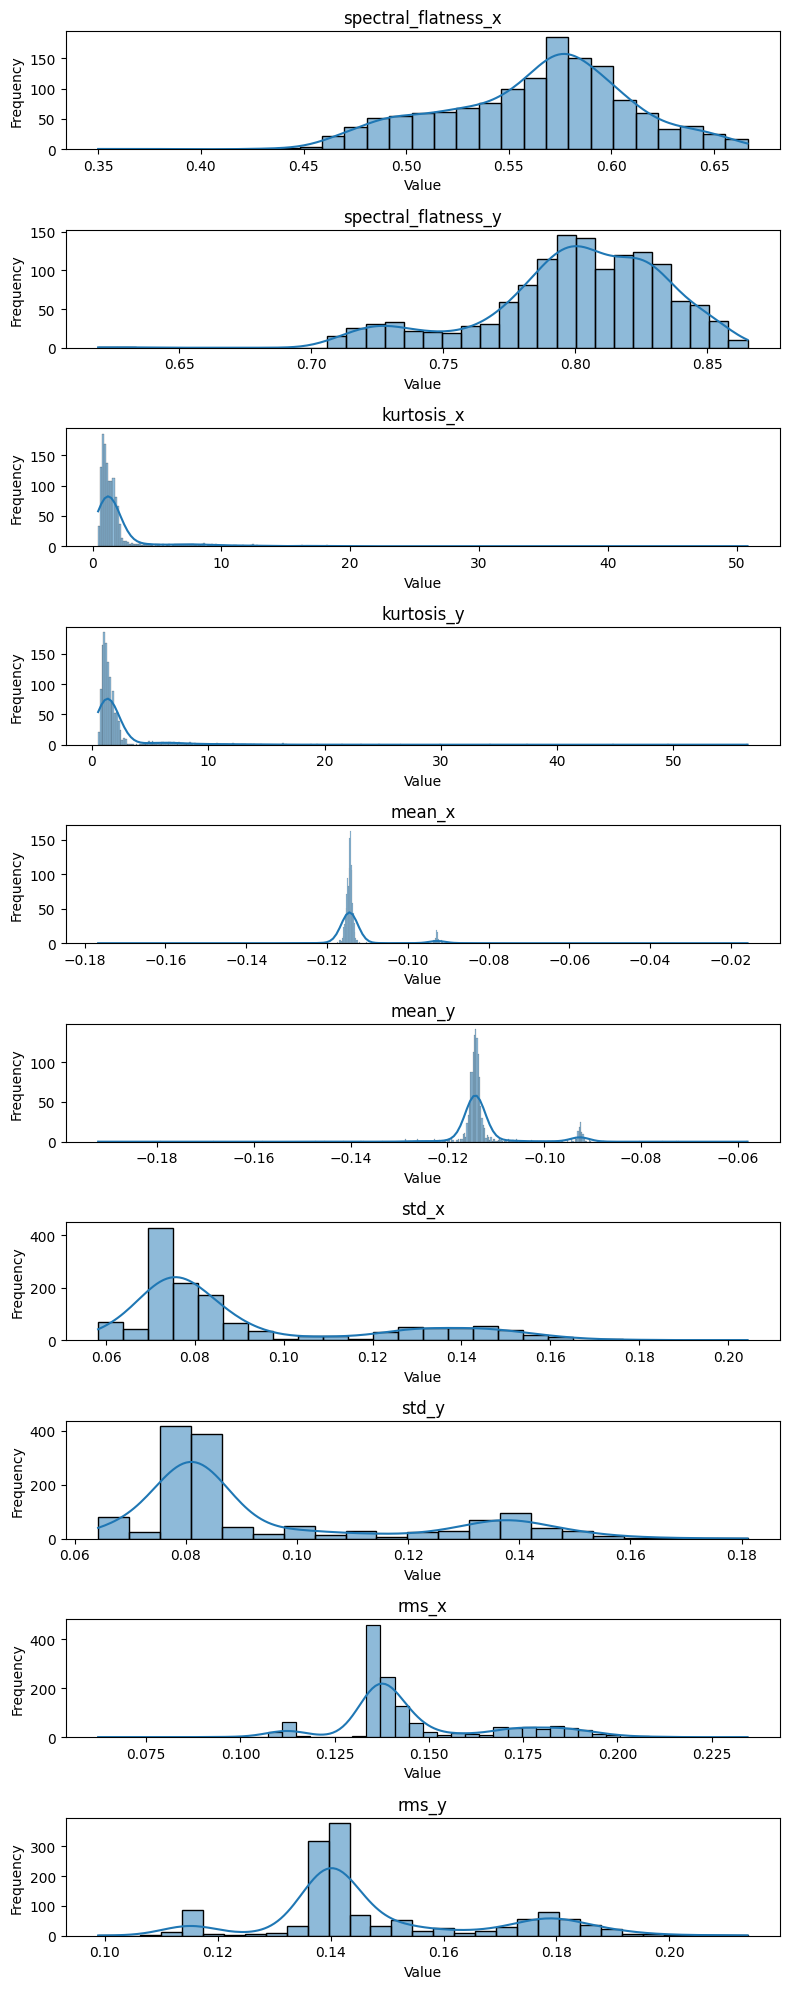

In [20]:
# Create a figure with subplots for each feature to visualize the distribution
fig, axs = plt.subplots(nrows=len(features), ncols=1, figsize=(8, 20))

# Loop through each feature and create a histogram
for i, feature in enumerate(features):
    sns.histplot(X_train[feature], ax=axs[i], kde=True)
    axs[i].set_title(feature)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [21]:
# Check whether the data's selected_ have multicollinearity.
from statsmodels.stats.outliers_influence import variance_inflation_factor
selected_features = ['spectral_flatness_y', 'kurtosis_y', 'std_y']
def vif(X):
    col_vif = [] # placeholder to store the vif values
    for i in range(len(selected_features)):
        vif = variance_inflation_factor(X[selected_features],i)
        col = selected_features[i]
        col_vif.append((col,vif))
    vif_df = pd.DataFrame(data=col_vif,columns=['Feature','VIF'])

    return vif_df

vif = vif(X_train)
vif
# plt.figure(figsize=(10, 6))
# plt.barh(vif['variable'], vif['VIF'])
# plt.xlabel('VIF')
# plt.ylabel('Feature')
# plt.title('Variance Inflation Factor (VIF)')
# plt.show()
# High multicollinearity.

,Feature,VIF
0,spectral_flatness_y,14.114528
1,kurtosis_y,1.754718
2,std_y,16.469404


In [22]:
# Handle class imbalance using SMOTE
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

# tsne = TSNE(n_components=3)
# df_tsne = tsne.fit_transform(feature_df)

In [23]:

# ElasticNet for feature selection
elastic_net = ElasticNet()

# Parameter grid for Elastic Net's hyperparameter tuning
param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0]
}

# Hyperparameter tuning with GridSearchCV
grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=5)
grid_search.fit(X_train_pca, y_train)

# Extract n features based on the coefficients
# (the further from zero, the better)
best_elastic_net = grid_search.best_estimator_
selected_features = X.columns[np.where(abs(best_elastic_net.coef_) > 0.1)[0]]

# Print the selected features
print("Selected features:", selected_features)

Selected features: Index(['spectral_flatness_x', 'spectral_flatness_y', 'kurtosis_x', 'mean_y'], dtype='object')


In [24]:
# Using only relevant features for the model
X = feature_df[selected_features]
y = feature_df['b4_state']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=6, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

ValueError: n_components=6 must be between 0 and min(n_samples, n_features)=4 with svd_solver='full'

In [ ]:
tsne_data = np.vstack((tsne_data.T, y)).T
tsne_df = pd.DataFrame(data = tsne_data,
    columns =('Dim_1', 'Dim_2', 'state'))

NameError: name 'tsne_data' is not defined

## d. We have used the standard deviation and the rms. However, these features are highly correlated. Explain why these features are highly correlated (either in words or mathematically).

In [ ]:
# Firstly we can examine what the formula is for both features:
# RMS = sqrt( (1/N) * sum(x_i^2) )
# Stdev = sqrt( (1/N) * sum((x_i - mean)^2) )

# While they both aim to calculate the variability of the data, they do it slightly differently
# since Stdev considered the data's mean and RMS does not.

# However, these features will become increasingly similar as the mean approaches zero
# Where the mean is approximately zero, (x_i - mean) in Stdev becomes x_i -- just like in RMS.

# And small mean values are the case in this data, as we can see from the results of the features function in b.
# Therefore, it makes sense why these values are highly correlated.

## e. (1) Make one or several machine learning models to predict the degradation stage based on the features calculated in the previous exercises. Explain why you chose these models and their parameters.

In [ ]:
# Since we dealt with many outliers in the data and feature dependencies,
# we need to scale and then reduce the dimension of the data.

# If we want to use log regression or linear regression,
# we also need to transform as the distributions of the features are now non-normal
# quantile_transformer = QuantileTransformer(output_distribution='normal')
# X_quantile_scaled = quantile_transformer.fit_transform(X_train_pca)
# X_test_quantile_scaled = quantile_transformer.transform(X_test_pca)


In [ ]:
# Change n_features_to_select = 2 then grid search then find these params
grf = RandomForestClassifier(max_depth=6, n_estimators=200, random_state=42)

# gcrf = GridSearchCV(rf, param_grid={
#     'n_estimators': [10, 50, 100, 200],
#     'max_depth': [None, 4, 6, 8, 10]},
#     cv = 3, n_jobs = -1,
#     verbose=3, scoring = 'recall_weighted')

grf.fit(X_rfe, y_train)
# grf = gcrf.best_estimator_
y_pred = grf.predict(X_test_rfe)
y_pred_tr = grf.predict(X_rfe)
train_acc = accuracy_score(y_train, y_pred_tr)
test_acc = accuracy_score(y_test, y_pred) 
print(grf)
print(classification_report(y_test, y_pred))
print('Accuracy:', train_acc)
print('Accuracy:', test_acc)

# plt.plot(np.arange(150, 200), t)
# plt.plot(np.arange(150, 200), te)
# y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
# y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2, 3, 4])

# roc_auc = roc_auc_score(y_test_bin, y_pred_bin, average='macro')
# print(f'ROC AUC: {roc_auc}')

# It is overfitting because there is a huge gap between
# the accuracy score between train and test set.

RandomForestClassifier(max_depth=6, n_estimators=200, random_state=42)
              precision    recall  f1-score   support

           0       0.96      0.90      0.93        29
           1       0.83      0.96      0.89       143
           2       0.85      0.62      0.72        66
           3       1.00      0.86      0.93        58
           4       0.91      1.00      0.95        49

    accuracy                           0.88       345
   macro avg       0.91      0.87      0.88       345
weighted avg       0.88      0.88      0.87       345

Accuracy: 0.9079042784626541
Accuracy: 0.8782608695652174


In [ ]:
from sklearn.pipeline import Pipeline
rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)

# Create a pipeline with scaling, PCA, and a classifier
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42))
])

# Define parameter grid for PCA and classifier
param_grid = {
    'pca__n_components': np.arange(1, X.shape[1]+1)
    # 'clf__max_depth': [None, 2, 4, 6, 8, 10]
}

# Grid search cross-validation
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=-1,
                           verbose=3, scoring='f1_weighted')

grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Accuracy:", grid_search.best_score_)

# Evaluate the best model on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_tr = best_model.predict(X_train)
print('Accuracy (Train):', accuracy_score(y_train, y_pred_tr))
print('Accuracy (Test):', accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Parameters: {'pca__n_components': 2}
Best Cross-validation Accuracy: 0.7588920190504848
Accuracy (Train): 0.7412935323383084
Accuracy (Test): 0.7451737451737451
              precision    recall  f1-score   support

           0       1.00      0.08      0.15        38
           1       0.66      0.99      0.80       200
           2       0.78      0.34      0.48       102
           3       0.94      0.75      0.83       102
           4       0.81      0.97      0.89        76

    accuracy                           0.75       518
   macro avg       0.84      0.63      0.63       518
weighted avg       0.79      0.75      0.71       518



In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2, 3, 4])

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, average='macro')
print(f'ROC AUC: {roc_auc}')

ROC AUC: 0.9149164357884925


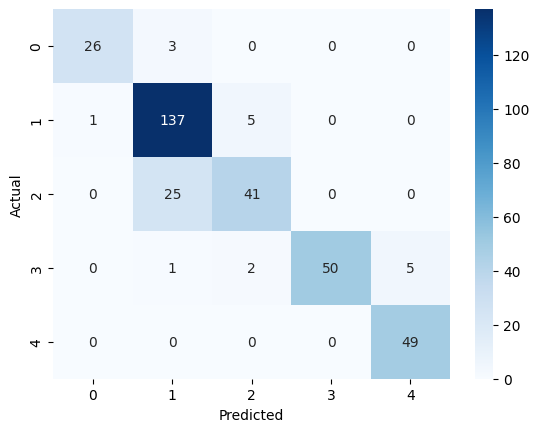

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
importances = grf.feature_importances_
feature_series = pd.Series(importances,
                           index=X.columns)

sorted_features = feature_series.sort_values(ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features.index, sorted_features.values)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance - Random Forest Regressor")
plt.gca().invert_yaxis() # To sort them based on feature importances
plt.tight_layout()
plt.show()

ValueError: Length of values (6) does not match length of index (10)

# Bagging Regressor

In [ ]:
bagr = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                        random_state=42)

# Tune the parameters with GridSearchCV
param = {'n_estimators': [10, 50, 100, 200, 300]}
gcv_bagr = GridSearchCV(bagr,
                        param_grid = param,
                        cv=5, scoring='accuracy')

gcv_bagr.fit(X_rfe, y_train)
best_bagr = gcv_bagr.best_estimator_

# Evaluate on test set
y_pred = best_bagr.predict(X_test_rfe)
y_pred_tr = best_bagr.predict(X_rfe)
print('Train Set Accuracy:', accuracy_score(y_train, y_pred_tr))
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", test_accuracy)

print(classification_report(y_test, y_pred))

Train Set Accuracy: 0.9985496736765772
Test Set Accuracy: 0.8753623188405797
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        29
           1       0.88      0.89      0.89       143
           2       0.77      0.74      0.75        66
           3       0.94      0.88      0.91        58
           4       0.90      0.96      0.93        49

    accuracy                           0.88       345
   macro avg       0.88      0.89      0.88       345
weighted avg       0.88      0.88      0.87       345



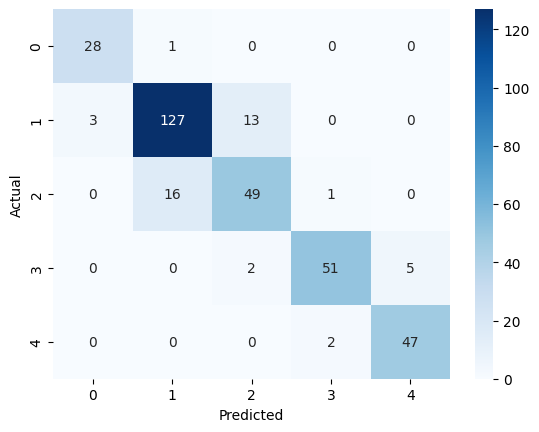

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2, 3, 4])

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, average='macro')
print(f'ROC AUC: {roc_auc}')

ROC AUC: 0.906163011820724


In [ ]:
model = MLPClassifier(
    hidden_layer_sizes=(5, 10),
    activation='relu',
    solver='adam',
    max_iter=5000, random_state=42
)
result = model.fit(
    X=X_train,
    y=y_train
)

y_pred = result.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_train, result.predict(X_train)))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91        38
           1       0.89      0.94      0.92       200
           2       0.85      0.75      0.80       102
           3       0.93      0.69      0.79       102
           4       0.72      0.96      0.82        76

    accuracy                           0.86       518
   macro avg       0.86      0.85      0.85       518
weighted avg       0.87      0.86      0.85       518

0.8316749585406302
